## Navigation <a class="anchor" id="menu"></a>

#### Day 1

0. [Introduction](#intro)
1. [Import packages](#setup)
2. [Get the data](#data)
3. [Data exploration](#init_edit)
4. [Feature engineering](#feature_engineering)
5. [Final training](#model)
    - [Evaluation metrics](#metrics)
    - Common pitfalls
        - [Leakage](#leakage)
        - [Overfitting](#overfit)
    - [Boosted trees](#boosted_tree)
    - [Random forest](#random_forest)
    - [Visualising the results](#visualisation)
    
6. [Hackathon time!](#hackathon)

# Introduction <a class="anchor" id="intro"></a>
[Back to top](#menu)

### Problem at hand
<p> We are going to try to predict weekly grocery expenses of families based on the data we have collected about them over the course of 2 years.</p>


### Data
<p> We have data on: </p>
<ul>
<li> demographic information of families </li>
<li> transactions, per item they bought </li>
<li> details about the products in the grocery store </li>
<li> campaign that were in effect every week </li>
<li> special promotions per each family </li>
</ul>
    
### Method
Our target is the weekly spending amount but the data we have collected is in different formats. Some of them are per week and some of them are per day. So, going forward, we will have to aggregate and alter the data to turn it into the format we wish to have.

Steps:
<li> Importing and exploring the dataset </li>
<li> Doing the necessary changes to the data to have it in the format we need </li>
<li> Extracting more information from the raw data we collected </li>

### Learning outcomes

Through this hands-on session we will learn:
* Best practices
* Common pitfalls to avoid
* Data Science tools and how/when to use them

# 1. Import packages and define functions <a class="anchor" id="setup"></a>
[Back to top](#menu)

In [ ]:
!pip install shap

In [80]:
# necessary imports and functions
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import math
import random
import pixiedust

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import shap



pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)
matplotlib.rcParams.update({'font.size': 20})

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = [x+1 for x in y_true]
    y_pred = [x+1 for x in y_pred]
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def training_testing_metrics(X_train, y_train, X_test, y_test, model):
    y_pred_train = model.predict(X_train)
    
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = math.sqrt(mse_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train) 
    
    preds = model.predict(X_test)
    
    mae_test = mean_absolute_error(y_test, preds)
    mse_test = mean_squared_error(y_test, preds)
    rmse_test = math.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test, preds)
    r2_test = r2_score(y_test, preds) 
    
    metrics = {'metrics':['mean absolute error','mean squared error','root mean squared error','mean absolute percentage error','r2'],'training': [mae_train,mse_train,rmse_train,mape_train,r2_train], 'testing': [mae_test,mse_test,rmse_test,mape_test,r2_test]}
    return pd.DataFrame(data=metrics)

# 2. Reading data <a class="anchor" id="data"></a>
[Back to top](#menu)

In [81]:

# from ibmdbpy import IdaDataBase, IdaDataFrame

# # @hidden_cell
# # This connection object is used to access your data and contains your credentials.
# # You might want to remove those credentials before you share your notebook.

# idadb_b3e7834f1aa143dab76e6ff65365d57c = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=vzr40997;PWD=v^jpb6cht1d6d3h2')

# df_campaigns = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.CAMPAIGNS').as_dataframe()
# df_demographics = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.DEMOGRAPHICS').as_dataframe()
# df_products = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.PRODUCTS').as_dataframe()
# df_transactions = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.TRANSACTIONS').as_dataframe()
# df_promotions = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.PROMOTIONS').as_dataframe()

# print('Data loading complete!')
# idadb_b3e7834f1aa143dab76e6ff65365d57c.close()


In [82]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_70fd47c6e71c4e0c83d1186d35642876 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XAPmueeL_Iv_-QC7CMfDnd4S0Rxv-O97SDOwZGQGdX8-',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_70fd47c6e71c4e0c83d1186d35642876.get_object(Bucket='apd-donotdelete-pr-tvficp3uyk6ggh',Key='campaigns.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_campaigns = pd.read_csv(body)
df_campaigns.head()

body = client_70fd47c6e71c4e0c83d1186d35642876.get_object(Bucket='apd-donotdelete-pr-tvficp3uyk6ggh',Key='demographics.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df_demographics = pd.read_csv(body)
df_demographics.head()

body = client_70fd47c6e71c4e0c83d1186d35642876.get_object(Bucket='apd-donotdelete-pr-tvficp3uyk6ggh',Key='products.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_products = pd.read_csv(body)
df_products.head()

body = client_70fd47c6e71c4e0c83d1186d35642876.get_object(Bucket='apd-donotdelete-pr-tvficp3uyk6ggh',Key='promotions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_promotions = pd.read_csv(body)
df_promotions.head()

body = client_70fd47c6e71c4e0c83d1186d35642876.get_object(Bucket='apd-donotdelete-pr-tvficp3uyk6ggh',Key='transactions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_transactions = pd.read_csv(body)
df_transactions.head()

body = client_70fd47c6e71c4e0c83d1186d35642876.get_object(Bucket='apd-donotdelete-pr-tvficp3uyk6ggh',Key='train_ready_with_leakage.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

all_data = pd.read_csv(body)
all_data.head()


,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS,days_since_last_shopping,amount_spent_last_trip,amount_spent_last_week,weeks_since_last_shopping,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time,weighted_avg_trips,weighted_avg_weeks,avg_visits_per_week,avg_visits_per_month,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-4,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-2,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-6,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
# df_transactions = pd.read_csv('data/transactions.csv')
# df_demographics = pd.read_csv('data/demographics.csv')
# df_products = pd.read_csv('data/products.csv')
# df_promotions = pd.read_csv('data_new/promotions.csv')
# df_campaigns = pd.read_csv('data/campaigns.csv')

# print('Data loading complete!')

# 3. Data exploration <a class="anchor" id="init_edit"></a>
[Back to top](#menu)

In [84]:
d = {'df_transactions': df_transactions.columns.tolist(), 'df_products': df_products.columns.tolist(),
    'df_campaigns': df_campaigns.columns.tolist(), 'df_promotions': df_promotions.columns.tolist(),
    'df_demographics': df_demographics.columns.tolist()}

all_dfs = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
all_dfs = all_dfs.fillna('')
all_dfs


,df_transactions,df_products,df_campaigns,df_promotions,df_demographics
0,DAY,PRODUCT_ID,WEEK_NO,WEEK_NO,HOUSEHOLD_KEY
1,WEEK_NO,DEPARTMENT,NUM_CAMPAIGNS,HOUSEHOLD_KEY,AGE_MEAN
2,HOUSEHOLD_KEY,COMMODITY_DESC,FUEL_PRICE_DIFF,NUM_COUPONS,HOUSEHOLD_SIZE
3,PRODUCT_ID,,,TIME_IN_APP,NUM_ADULTS
4,SALES_VALUE,,,WEEKLY_BONUS_POINTS,NUM_CHILDREN
5,QUANTITY,,,,MARITAL_STATUS
6,DISCOUNT,,,,INCOME_MEAN


In [85]:
all_datasets_merged = df_transactions.merge(df_products, on='PRODUCT_ID', how='left').merge(df_campaigns, on='WEEK_NO', how='left').merge(df_promotions, on=['WEEK_NO','HOUSEHOLD_KEY'], how='left').merge(df_demographics, on='HOUSEHOLD_KEY', how='left')
all_datasets_merged.head()



,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT,DEPARTMENT,COMMODITY_DESC,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN
0,1,1,98,782443249,0.39,1.0,0.00,PRODUCE,TROPICAL FRUIT,0,-8,0,77.44,NaN,40,2,1,1,NaN,42000
1,1,1,98,3112548822,3.00,2.0,-0.08,GROCERY,COOKIES/CONES,0,-8,0,77.44,NaN,40,2,1,1,NaN,42000
2,1,1,98,6571651611,1.15,4.0,0.00,GROCERY,BAG SNACKS,0,-8,0,77.44,NaN,40,2,1,1,NaN,42000
3,1,1,98,8840487053,1.25,1.0,-0.34,GROCERY,BAKED SWEET GOODS,0,-8,0,77.44,NaN,40,2,1,1,NaN,42000
4,1,1,212,782443249,0.65,1.0,0.00,PRODUCE,TROPICAL FRUIT,0,-8,0,67.24,NaN,40,1,1,0,NaN,15000



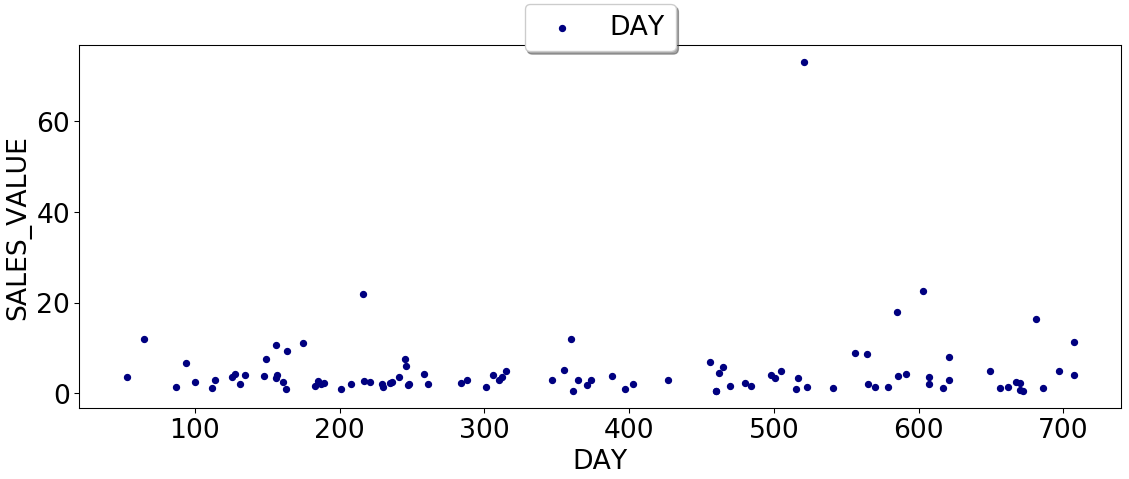

In [ ]:
display(all_datasets_merged)

In [87]:
# PLACEHOLDER : AI Fairness Tool

# 4. Feature Engineering <a class="anchor" id="feature_engineering"></a>
[jump to end of this part](#bring_together)
[Back to top](#menu)

In [88]:
all_data.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS,days_since_last_shopping,amount_spent_last_trip,amount_spent_last_week,weeks_since_last_shopping,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time,weighted_avg_trips,weighted_avg_weeks,avg_visits_per_week,avg_visits_per_month,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-4,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-2,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-6,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5. Train a model <a class="anchor" id="model"></a>
[Back to top](#menu)

### Choose the feature to use in training

In [154]:
exclude_columns = ['WEEK_NO','HOUSEHOLD_KEY','year', 'month', 'season']

training_columns = [x for x in all_data.columns if x not in exclude_columns]

columns_to_predict_on = [x for x in training_columns if x != 'SALES_VALUE']

training_data = all_data[training_columns]

training_data = training_data.dropna()
# training_data = training_data[training_data['SALES_VALUE']<400]

In [155]:
training_data.shape

(32855, 52)

<h3> Train and test split </h3>

In [156]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(32855, 51)


## Boosted Trees - Leakage <a class="anchor" id="leakage"></a>

In [157]:
xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=50, eval_metric='rmse', n_estimators=50)

# xgboost = xgb.XGBRegressor(objective="reg:squarederror", max_depth=10, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=50, subsample=0.5)
# xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=5, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=300, subsample=0.5) # best

xgb_pipeline = Pipeline([('regressor', xgboost)])
    
xgb_model = xgb_pipeline.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

training_testing_metrics(X_train, y_train, X_test, y_test, xgb_model)

,metrics,training,testing
0,mean absolute error,0.556695,4.682977
1,mean squared error,1.719750,93.331504
2,root mean squared error,1.311392,9.660823
3,mean absolute percentage error,0.675861,8.883980
4,r2,0.999692,0.984046


### Oops. We might have made a mistake! 😅 There is a data leakage.
<p> Leakage happens when: </p>
A feature that is highly related to the target feature (and/or is determined by the target feature) is left as a training feature. 
    In this example, we left the feature "QUANTITY" in the training set. The amount people spent on their groceries is highly effected by how many items they bought. And additionally, when one wants to predict the amount to be spent on a shopping trip in the future, one cannot use the Quantity information simply because we don't know that yet. That's why, we have to make sure that we don't include this type of dependent features in our training set.

### Fix leakage

In [158]:
# fix leakage problem
all_data_leak_proof = all_data.copy()
all_data_leak_proof['QUANTITY'] = all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)
all_data_leak_proof['DISCOUNT'] = all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)
all_data_leak_proof['TIME_IN_APP'] =  all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['TIME_IN_APP'].shift(1)
training_data = all_data_leak_proof[training_columns]

In [159]:
training_data = training_data.dropna()
# training_data = training_data[training_data['SALES_VALUE']<400]

<h3> Train and test split </h3>

In [185]:
# training_data = training_data.sample(10000)
X = training_data[columns_to_predict_on]
# X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(33174, 51)


## Boosted Trees - Overfit <a class="anchor" id="overfit"></a>

In [201]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=50, n_estimators=50)

# xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=10, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=50, subsample=0.5)
# xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=5, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=300, subsample=0.5) # best

xgb_pipeline = Pipeline([('regressor', xgboost)])
    
xgb_model = xgb_pipeline.fit(X_train, y_train)
# xgboost.fit(X_train, y_train)
xgboost.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, verbose=False)

training_testing_metrics(X_train, y_train, X_test, y_test, xgb_model)


,metrics,training,testing
0,mean absolute error,0.875566,34.340721
1,mean squared error,4.611931,2498.375287
2,root mean squared error,2.147541,49.983750
3,mean absolute percentage error,1.141594,517.340970
4,r2,0.999172,0.570498


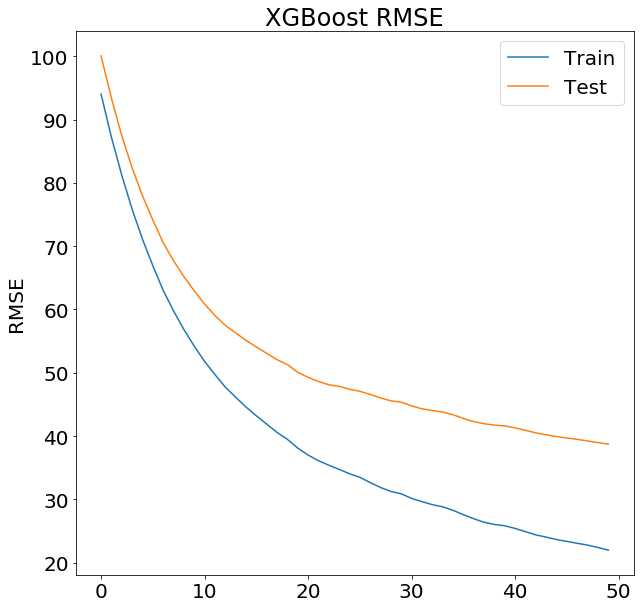

In [207]:
matplotlib.rcParams.update({'font.size': 20})
results = xgboost.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()

pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()


### Looks like our model overfit!

<p> Overfitting occurs when there is: </p>
<ul>
<li> too little data </li>
<li> too complex of a model </li>
<li> biased/unbalanced train-test split </li>
</ul>

## Boosted Trees <a class="anchor" id="boosted_tree"></a>

In [203]:
eval_set = [(X_train, y_train), (X_test, y_test)]
# xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=50, eval_metric='rmse', n_estimators=50)

xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=10, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=50, subsample=0.5)
# xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=5, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=300, subsample=0.5) # best

xgb_pipeline = Pipeline([('regressor', xgboost)])
    
xgb_model = xgb_pipeline.fit(X_train, y_train)
xgboost.fit(X_train, y_train, eval_set=eval_set, verbose=False)

training_testing_metrics(X_train, y_train, X_test, y_test, xgb_model)

,metrics,training,testing
0,mean absolute error,16.483096,26.650365
1,mean squared error,482.987160,1498.361311
2,root mean squared error,21.976969,38.708672
3,mean absolute percentage error,302.132535,423.484264
4,r2,0.913281,0.742413


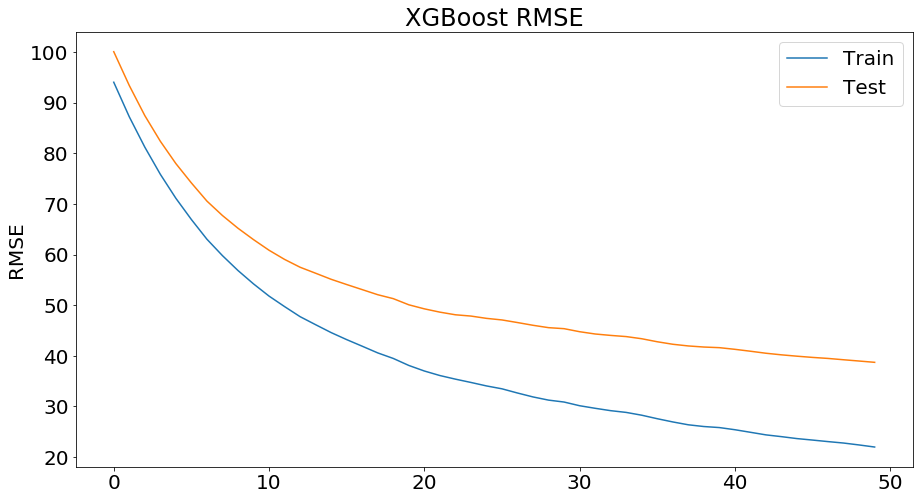

In [210]:
matplotlib.rcParams.update({'font.size': 20})
results = xgboost.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()

pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()


## Random Forest <a class="anchor" id="random_forest"></a>

In [189]:
rf = RandomForestRegressor(n_estimators=100, random_state = 42)

rf_pipeline = Pipeline([('regressor', rf)])
    
rf_model = rf_pipeline.fit(X_train, y_train)

training_testing_metrics(X_train, y_train, X_test, y_test, rf_model)

,metrics,training,testing
0,mean absolute error,11.378370,34.397898
1,mean squared error,272.531582,2370.968209
2,root mean squared error,16.508531,48.692589
3,mean absolute percentage error,202.031529,637.244741
4,r2,0.951068,0.592401


# Visualising the results <a class="anchor" id="visualisation"></a>

In [165]:
predictions = xgboost.predict(X_test)
results = pd.DataFrame(columns=['real','predicted'], data={'real':y_test, 'predicted':predictions}).reset_index().drop('index',axis=1)
results = results.astype('float')

In [166]:
results.head()

,real,predicted
0,0.00,10.713911
1,21.73,17.908560
2,23.54,19.151880
3,0.00,22.915363
4,22.78,38.534260



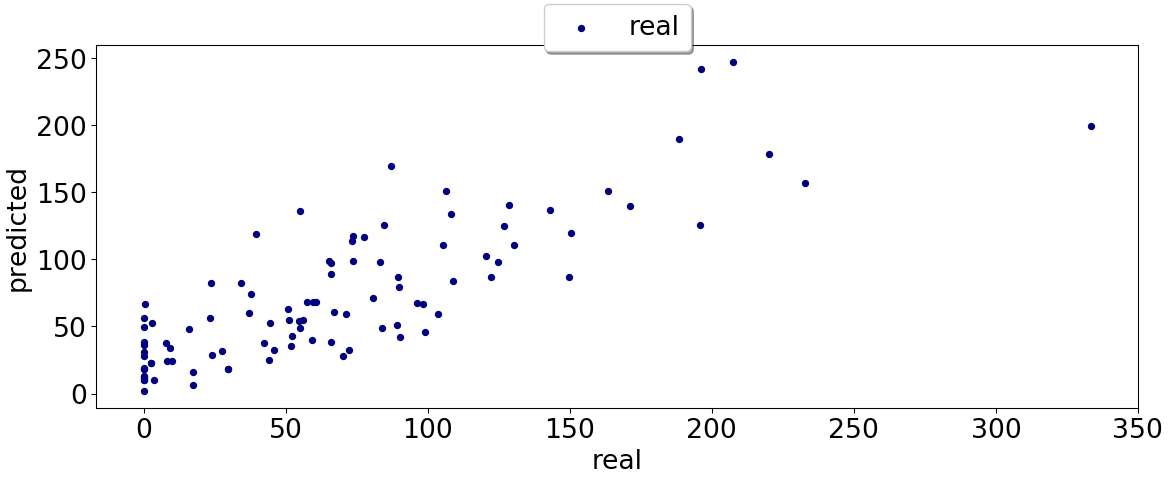

In [102]:
display(results)

# 6. Hackathon time! <a class="anchor" id="hackathon"></a>

# 7. Model explanability <a class="anchor" id="explanability"></a>

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgboost)
shap_values_global = explainer.shap_values(train_x)
shap.summary_plot(shap_values_global, train_x, plot_type="bar", feature_names = np.array(X.columns))

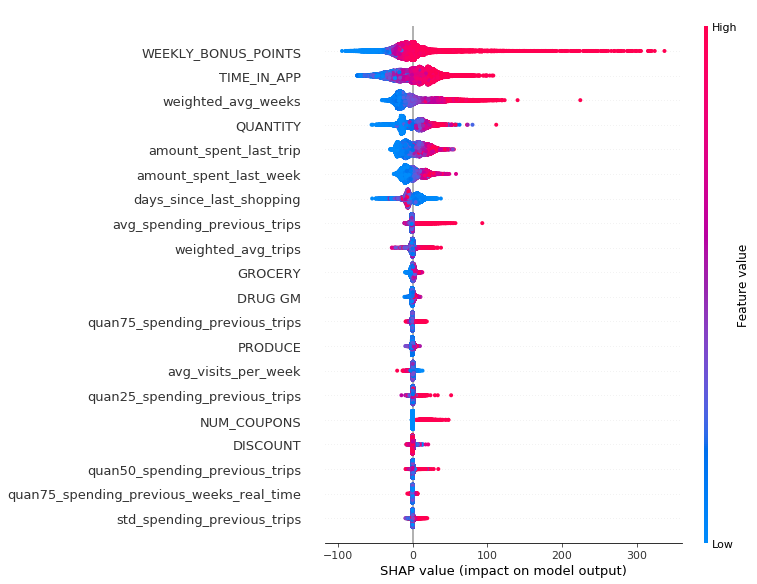

In [234]:
shap.summary_plot(shap_values_global, train_x, feature_names = np.array(X.columns))

In [ ]:
sample_index=5

shap.initjs()
shap_values = explainer.shap_values([test_x[sample_index]])
shap.force_plot(explainer.expected_value,
                           shap_values,
                           test_x[sample_index],
                           feature_names = np.array(X.columns))